In [2]:
pip install fastdtw

In [3]:
from scipy.ndimage import filters
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import numpy as np
import cv2

In [4]:
def showpic(image, width=10):
  plt.figure(figsize=(width, width/1000*727))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

def showlist(tiles, width=10):
  n_rows = np.ceil(len(tiles)/5).astype('int')
  plt.subplots(n_rows, 5, figsize=(width, width))
  for i in range(len(tiles)):
     plt.subplot(n_rows, 5, i+1)
     plt.axis('off')
     plt.title(str(i))
     plt.imshow(tiles[i])
  plt.show()

(727, 1000, 4)


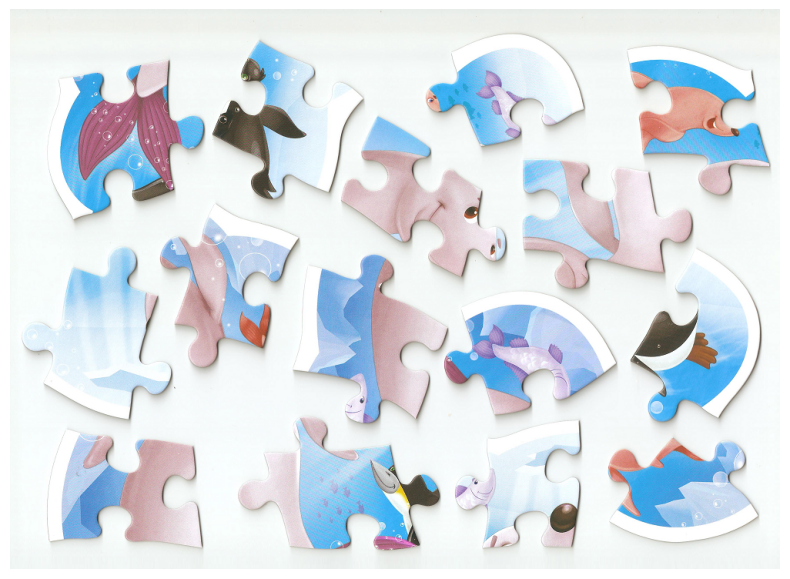

In [5]:
puzzle = np.array(Image.open('puzzle.png').convert('RGBA'))
print(puzzle.shape)
showpic(puzzle)

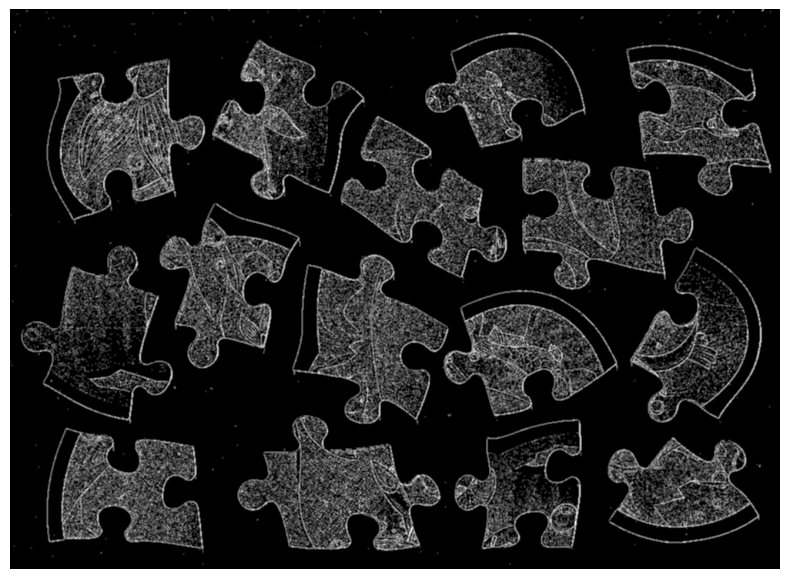

In [6]:
# Adaptive thresholding
thresh = cv2.cvtColor(puzzle, cv2.COLOR_RGBA2GRAY)
thresh = cv2.adaptiveThreshold(thresh, 255, 0, 1, 3, 3)
thresh = cv2.GaussianBlur(thresh, (3,3), 1)
showpic(thresh)

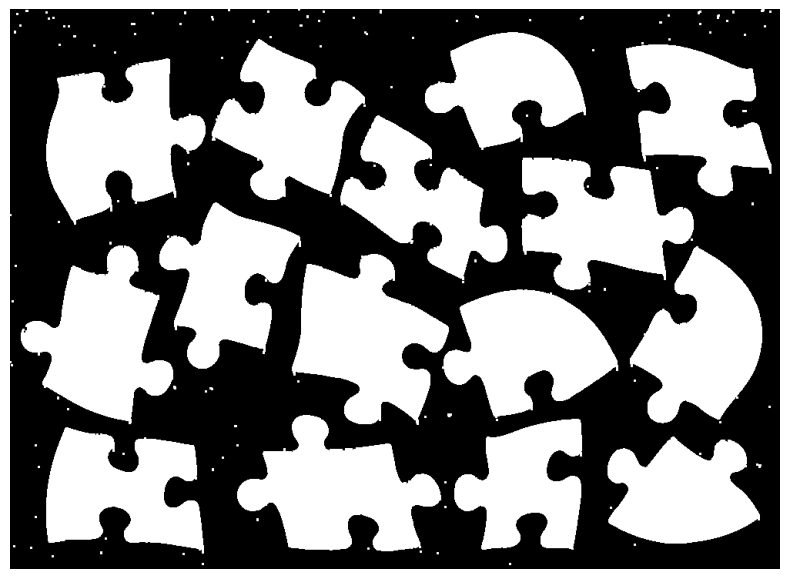

In [7]:
contours, _ = cv2.findContours(thresh, 0, 1)
sorted = sorted([[cnt.shape[0], i] for i, cnt in enumerate(contours)], reverse=True)[:]
biggest = [contours[s[1]] for s in sorted]
fill = cv2.drawContours(np.zeros(puzzle.shape[:2]), biggest, -1, 255, thickness=cv2.FILLED)
showpic(fill)

<ipython-input-8-16c61f875eda>:2: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth = filters.median_filter(fill.astype('uint8'), size=10)


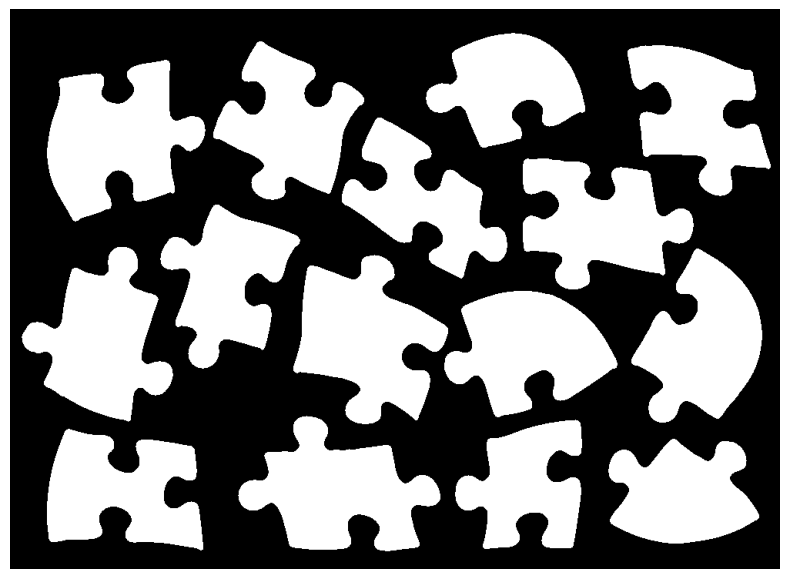

In [8]:
#  Smooth contours and trim shadows
smooth = filters.median_filter(fill.astype('uint8'), size=10)
trim_contours, _ = cv2.findContours(smooth, 0, 1)
cv2.drawContours(smooth, trim_contours, -1, color=0, thickness=1)
showpic(smooth)

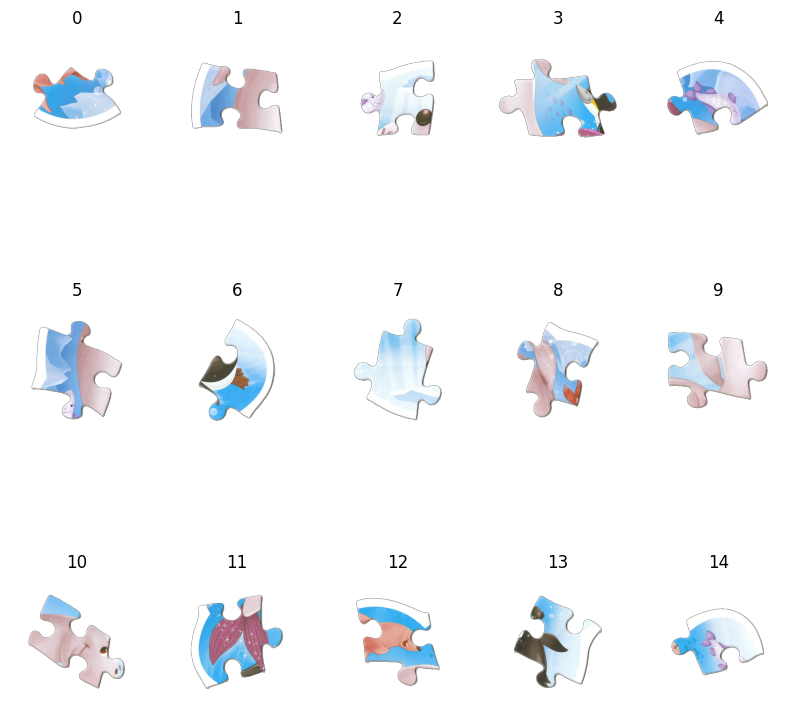

In [9]:
# Split into tiles
contours, _ = cv2.findContours(smooth, 0, 1)

tiles, tile_centers = [], []
for i in range(len(contours)):
  x, y, w, h = cv2.boundingRect(contours[i])
  shape, tile = np.zeros(puzzle.shape[:2]), np.zeros((300,300,4), 'uint8')
  cv2.drawContours(shape, [contours[i]], -1, color=1, thickness=-1)
  shape = (puzzle * shape[:,:,None])[y:y+h, x:x+w, :]
  tile[(300-h)//2:(300-h)//2+h,(300-w)//2:(300-w)//2+w] = shape
  tiles.append(tile)
  tile_centers.append((h//2+y, w//2+x))

showlist(tiles)

In [10]:
# Rescale tiles to assembly format
canvas_tiles = []
for i in range(len(tiles)):
  canvas_tile = np.zeros((1400,1400,4), 'uint8')
  canvas_tile[550:850, 550:850] = tiles[i].copy()
  canvas_tiles.append(canvas_tile)

In [11]:
def getColors(image, subcontour):
  subcontour = np.flip(subcontour)

  colors = []
  for n in range(len(subcontour)-3):
    (y,x) = subcontour[n]
    (y1,x1) = subcontour[n+3]
    h, w = y1 - y, x1 - x
    colors.append(image[y-w, x+h, :3] + image[y+w, x-h, :3])
  colors = np.array(colors, 'uint8').reshape(-1,1,3)
  colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV)

  return colors.reshape(-1,3)

def putOnAnvil(arr_img, point, angle, center=(700,700)):
  img = Image.fromarray(arr_img)
  img = ImageChops.offset(img, center[1] - point[1], center[0] - point[0])
  img = img.rotate(angle)
  return np.array(img)

def rotatePoint(point, angle, center=(700,700)):
  dy, dx = center[0]-point[0], point[1]-center[1]
  distance = np.sqrt(np.square(point[0]-center[0]) + np.square(point[1]-center[1]))
  if dx==0: dx = 1
  base = 90*(1-np.sign(dx)) + np.degrees(np.arctan(dy/dx))

  y = round(center[0] - distance * np.sin(np.pi * (base + angle)/180))
  x = round(center[1] + distance * np.cos(np.pi * (base + angle)/180))

  return (y,x)

def reScale(point, position, center=(150,150)):
  cy, cx, angle = position
  if angle!=0: (y, x) = rotatePoint(point, angle, center)
  else: (y, x) = point
  return (y + cy - center[0], x + cx - center[1])

In [12]:
def matchTiles(A, B):

  LENGTH = 160
  PRECISION = 8
  STEP_A = 20
  STEP_B = 7
  MAX_FORM = 0.015
  MAX_COLOR = 8000
  MAX_PIXEL = 0.03
  MAX_FIT = 0.77
  CENTER = round(LENGTH/2)

  tileA, tileB = tiles[A], tiles[B]
  cntA, _ = cv2.findContours(tileA[:,:,3], 0, 1)
  cntB, _ = cv2.findContours(tileB[:,:,3], 0, 1)
  cntA, cntB = cntA[0].reshape(-1,2), cntB[0].reshape(-1,2)
  sumLen = cntA.shape[0] + cntB.shape[0]

  # Contour matching
  form_matches = []
  for i in range(0, cntA.shape[0], STEP_A):

    # subcontour A and its type
    subcA = np.roll(cntA, -i, 0)[:LENGTH]
    pointA = tuple(np.flip(subcA[CENTER]))
    cA, (hA,wA), aA = cv2.minAreaRect(subcA)
    typepointA = np.int0(np.flip(subcA[0] + subcA[-1] - cA))
    typeA = tileA[:,:,3][tuple(typepointA)]
    a = cv2.drawContours(np.zeros((300,300),'uint8'), subcA.reshape(-1,1,2), -1, 255, 1)

    # loop through match subcontours
    for j in range(0, cntB.shape[0], STEP_B):

      # subcontour B and its type
      subcB = np.roll(cntB, -j, 0)[:LENGTH]
      pointB = tuple(np.flip(subcB[CENTER]))
      cB, (hB,wB), aB = cv2.minAreaRect(subcB)
      typepointB = np.int0(np.flip(subcB[0] + subcB[-1] - cB))
      typeB = tileB[:,:,3][tuple(typepointB)]

      # record good form matches
      if typeB != typeA:
        if ((abs(hA-hB) < PRECISION) & (abs(wA-wB) < PRECISION)) or ((abs(hA-wB) < PRECISION) & (abs(wA-hB) < PRECISION)):
          b = cv2.drawContours(np.zeros((300,300),'uint8'), subcB.reshape(-1,1,2), -1, 255, 1)
          fmatch = cv2.matchShapes(a,b,1,0)
          if fmatch < MAX_FORM:
            colinear = True if np.sign(hA-wA) == np.sign(hB-wB) else False
            if colinear:
              codirect = True if (np.sign(typepointA - np.flip(cA)) ==  np.sign(typepointB - np.flip(cB))).all() else False
            else:
              c = np.concatenate([np.sign(typepointA - np.flip(cA)), np.sign(typepointB - np.flip(cB))])
              codirect = True if (abs(np.sum(c[:3])) + abs(np.sum(c[-3:]))) == 4 else False
            if not colinear: aB = aB + 90
            if not codirect: aB = aB + 180
            form_matches.append([(i, j), pointA, pointB, round(aB-aA,4), round(fmatch,4)])

  # Color matching
  color_matches = []
  for n in range(len(form_matches)):
    (i, j), pointA, pointB, angle, fmatch = form_matches[n]

    subcA = np.roll(cntA, -i, 0)[:LENGTH]
    subcB = np.roll(cntB, -j, 0)[:LENGTH]
    colorsA = getColors(tileA, subcA)
    colorsB = getColors(tileB, subcB)

    cmatch = fastdtw(colorsA, np.flip(colorsB, axis=0))[0]
    if cmatch < MAX_COLOR:
      color_matches.append([(i, j), pointA, pointB, angle, fmatch, round(cmatch)])

  # Pre-fitting
  fit_matches = []
  for n in range(len(color_matches)):
    (i, j), pointA, pointB, angle, fmatch, cmatch = color_matches[n]
    a = putOnAnvil(canvas_tiles[A][:,:,3], reScale(pointA, [700,700,0]), 0)
    b = putOnAnvil(canvas_tiles[B][:,:,3], reScale(pointB, [700,700,0]), angle)

    loss = 1 - (np.sum((a+b)>0) / (np.sum(a>0) + np.sum(b>0)))
    contours, _ = cv2.findContours((a+b), 0, 1)
    fit = contours[0].shape[0] / sumLen
    if (loss < MAX_PIXEL) & (fit < MAX_FIT):
      fit_matches.append([(A, B), (i, j), pointA, pointB, angle, fmatch, cmatch, round(loss+fit,4), 0])

  fit_matches.sort(key=lambda n: n[-1])

  return fit_matches

In [13]:
matches = []
for a in range(len(tiles)-1):
  for b in range(a+1,len(tiles)):
    matches.extend(matchTiles(a,b))

# Flip and sort
for n in range(len(matches)):
  pair, ij, pointa, pointb, angle, fmatch, cmatch, fit, lock = matches[n]
  matches.extend([[(pair[1],pair[0]), ij, pointb, pointa, -angle, fmatch, cmatch, fit, lock]])
matches.sort(key=lambda m: (m[0], m[-2]))

In [14]:
def updateCanvas(canvas, positions, pointA, pointB, angleA, angleB):

  # update records for tiles on canvas
  for N, pos in enumerate(positions):
    if N in canvas:
      new_center = (pos[0] + 700 - pointA[0], pos[1] + 700 - pointA[1])
      new_center = rotatePoint(new_center, angleA)
      new_angle = pos[2] + angleA
      positions[N] = [*new_center, new_angle]

  # append record for the added tile
  canvas.append(B)
  center = rotatePoint((1400 - pointB[0], 1400 - pointB[1]), angleB)
  positions[B] = [*center, angleB]

  return canvas, positions

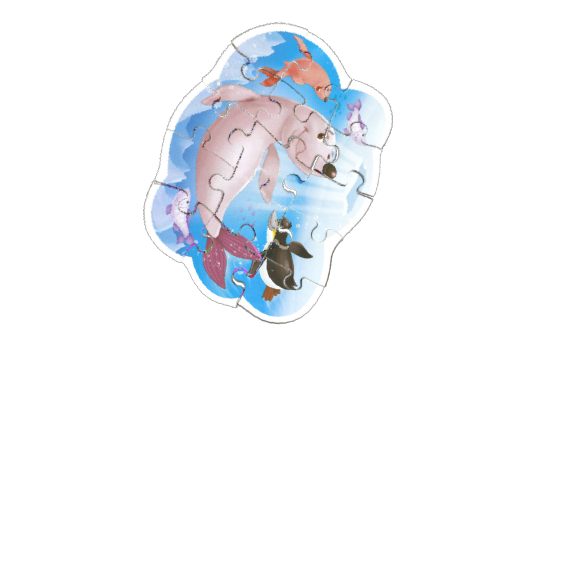

In [15]:
assembly = canvas_tiles[0].copy()
positions = [[0,0,0]]*len(tiles)
positions[0] = [700,700,0]
canvas = [0]
attempts = 0

while (len(canvas) < 15) & (attempts < 10):
  for n in range(len(matches)):

    # take next matching pair
    (A, B), ij, pointA, pointB, angleB, _, _, _, lock = matches[n]
    pointA = reScale(pointA, positions[A])
    pointB = reScale(pointB, (700,700,0))

    if A in canvas:
      angleA = - positions[A][2]
      pre_assembly = putOnAnvil(assembly.copy(), pointA, angleA)

      if B not in canvas:
        newtile = putOnAnvil(canvas_tiles[B], pointB, angleB)

        # fix or pass depending on loss of pixels
        loss = (np.sum(pre_assembly[:,:,3]>0) + np.sum(newtile[:,:,3]>0) -
                np.sum((pre_assembly+newtile)[:,:,3]>0)
                ) / np.sum(newtile[:,:,3]>0)
        if loss < 0.1:
          matches[n][-1] = 1
          assembly = pre_assembly.copy() + newtile.copy()
          canvas, positions = updateCanvas(canvas, positions,
                                           pointA, pointB, angleA, angleB)
  attempts += 1

showpic(assembly)

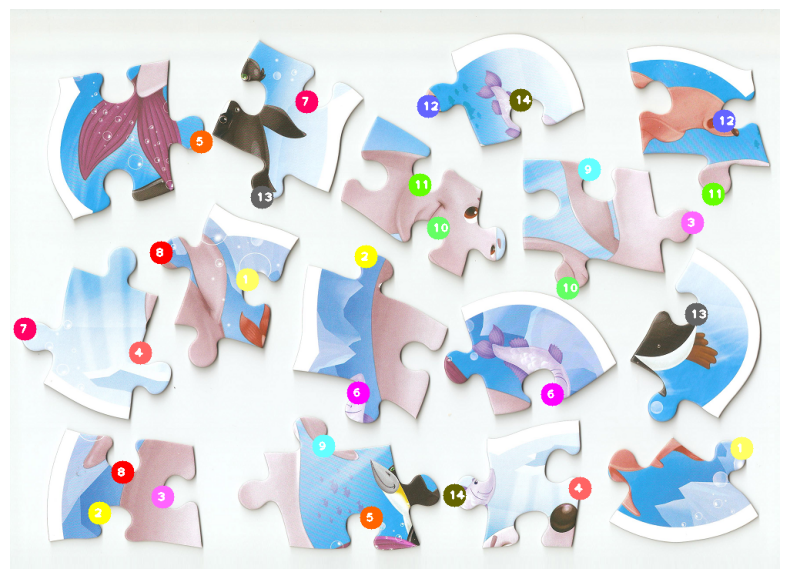

In [16]:
count = 0
markup = puzzle.copy()
colors = [[r,g,b,255] for r in [255,100,0] for g in [255,100,0] for b in [255,100,0]]

for n in range(len(matches)):
  (A, B), _, pointA, pointB, _, _, _, _, lock = matches[n]
  if lock == 1:
    count += 1
    centerA = (tile_centers[A][1]-(150-pointA[1]), tile_centers[A][0]-(150-pointA[0]))
    centerB = (tile_centers[B][1]-(150-pointB[1]), tile_centers[B][0]-(150-pointB[0]))
    cv2.circle(markup, centerA, 15, colors[count], -1)
    cv2.circle(markup, centerB, 15, colors[count], -1)
    cv2.putText(markup, str(count), (centerA[0]-7,centerA[1]+5), 1, 1, [255,255,255,255], 2)
    cv2.putText(markup, str(count), (centerB[0]-7,centerB[1]+5), 1, 1, [255,255,255,255], 2)

showpic(markup)